### Teofilus San Prasetya

# Autoencoder for Dimensionality Reduction and Image Reconstruction

**The MNIST dataset consists of 70,000 grayscale images of handwritten digits, ranging from 0 to 9, with each image measuring 28x28 pixels. This dataset is widely used in machine learning for tasks such as classification and image reconstruction. In the context of this project, the MNIST images are employed to train an autoencoder, which aims to reduce the dimensionality of the images from 784 (28x28) to 128. The primary objective is to evaluate the autoencoder's effectiveness in reconstructing the original images after encoding.**

**Load and scale the data, then display the sample data being used. After that, split the dataset into 80% training set, 10% validation set, and 10% test set.**

In [ ]:
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt

Train images shape: (12000, 28, 28, 1)
Test images shape : (2000, 28, 28, 1)


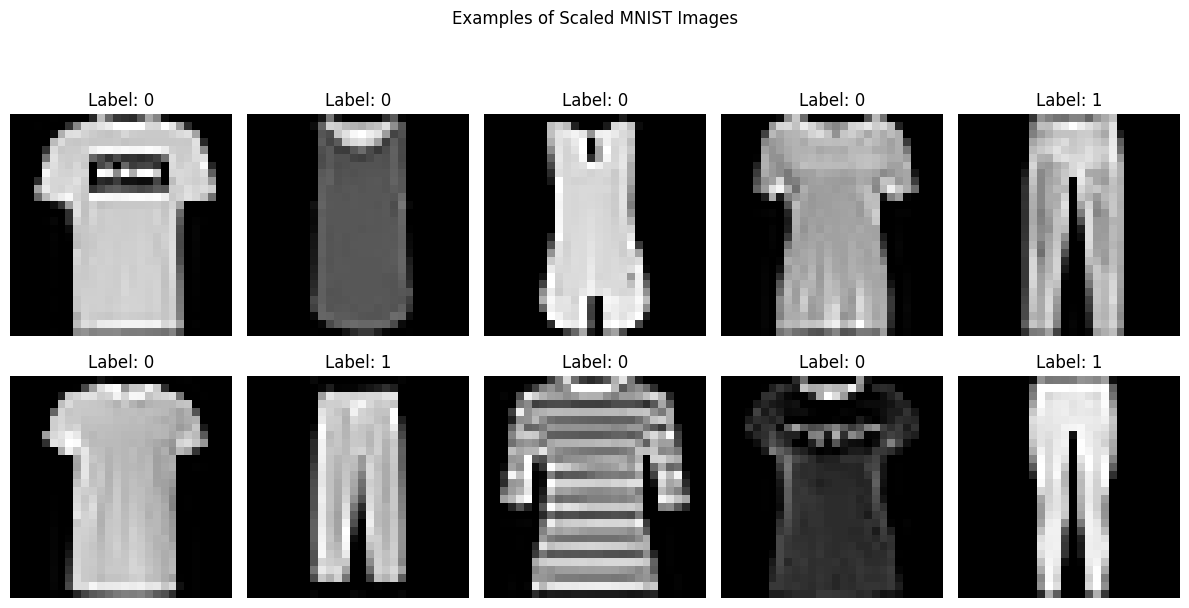

In [ ]:
def read_mnist_images(filepath, scale=True):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')

        # Read image data
        raw_data = f.read()
        images = np.frombuffer(raw_data, dtype=np.uint8)
        images = images.reshape(num_images, num_rows, num_cols)

        # Scale images to range [0, 1]
        if scale:
            images = images.astype('float32') / 255.0

        return images

def read_mnist_labels(filepath):
    with open(filepath, 'rb') as f:
        # Read header information
        magic_number = int.from_bytes(f.read(4), 'big')
        num_labels = int.from_bytes(f.read(4), 'big')

        # Read label data
        raw_data = f.read()
        labels = np.frombuffer(raw_data, dtype=np.uint8)

        return labels

def filter_classes(images, labels, class_list):
    # Filter images and labels based on class list
    mask = np.isin(labels, class_list)
    return images[mask], labels[mask]

def load_and_preprocess_mnist_images(image_filepath, label_filepath, class_list):
    # Load images and labels from file
    images = read_mnist_images(image_filepath)
    labels = read_mnist_labels(label_filepath)

    # Filter to keep only specified classes
    images_filtered, labels_filtered = filter_classes(images, labels, class_list)

    # Scale the images
    images_scaled = images_filtered.astype('float32') / 255.0

    return images_scaled, labels_filtered

# Define class labels
class_labels = {
    0: 'T-shirt/top',
    1: 'Trouser',
}

# File paths
train_images_filepath = 'train-images-idx3-ubyte'
train_labels_filepath = 'train-labels-idx1-ubyte'
test_images_filepath = 't10k-images-idx3-ubyte'
test_labels_filepath = 't10k-labels-idx1-ubyte'

# Load and preprocess dataset
train_images_scaled, train_labels_filtered = load_and_preprocess_mnist_images(train_images_filepath, train_labels_filepath, [0, 1])
test_images_scaled, test_labels_filtered = load_and_preprocess_mnist_images(test_images_filepath, test_labels_filepath, [0, 1])

# Add a 4th dimension for image input
train_images_scaled = np.expand_dims(train_images_scaled, axis=-1)
test_images_scaled = np.expand_dims(test_images_scaled, axis=-1)

# Shape of the scaled and filtered data
print("Train images shape:", train_images_scaled.shape)
print("Test images shape :", test_images_scaled.shape)

# Show 10 examples of scaled images
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images_scaled[i], cmap='gray')
    plt.title(f'Label: {train_labels_filtered[i]}')
    plt.axis('off')
plt.suptitle('Examples of Scaled MNIST Images', y=1.05)
plt.tight_layout()
plt.show()

Merged images shape: (14000, 28, 28, 1)
Merged labels shape : (14000,)


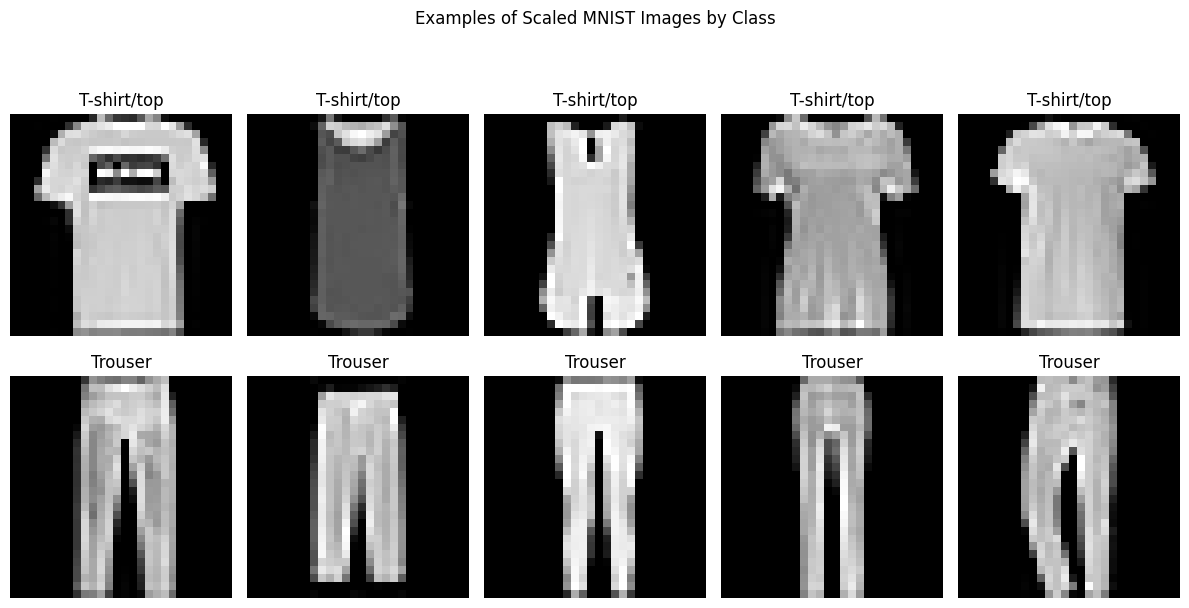

In [ ]:
# Merge 'T-shirt/top' and 'Trouser' data from train and test sets
merged_images = np.concatenate((train_images_scaled, test_images_scaled), axis=0)
merged_labels = np.concatenate((train_labels_filtered, test_labels_filtered), axis=0)

# Shape of the scaled and filtered data
print("Merged images shape:", merged_images.shape)
print("Merged labels shape :", merged_labels.shape)

# Display 5 examples of 'T-shirt/top' and 5 examples of 'Trouser'
plt.figure(figsize=(12, 6))

# Plotting T-shirt images
tshirt_indices = np.where(merged_labels == 0)[0][:5]
for i, idx in enumerate(tshirt_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(merged_images[idx], cmap='gray')
    plt.title(class_labels[0])
    plt.axis('off')

# Plotting Trouser images
trouser_indices = np.where(merged_labels == 1)[0][:5]
for i, idx in enumerate(trouser_indices):
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(merged_images[idx], cmap='gray')
    plt.title(class_labels[1])
    plt.axis('off')

plt.suptitle('Examples of Scaled MNIST Images by Class', y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
# Storing image data and labels into a dataframe
merged_data = []
for img, lbl in zip(merged_images, merged_labels):
    merged_data.append({'image': img.flatten(), 'label': lbl})

merged_data_mnist = pd.DataFrame(merged_data)

# DataFrame
print(merged_data_mnist.head())

                                               image  label
0  [0.0, 0.0, 0.0, 0.0, 0.0, 1.5378702e-05, 0.0, ...      0
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      0
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00016916...      0
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...      1


In [ ]:
from sklearn.model_selection import train_test_split

# Remove the 'label' column from the DataFrame to get features (X) and take the 'label' column as the target (y)
X = merged_data_mnist.drop(columns=['label'])
y = merged_data_mnist['label']

# Split the data into X_train_temp, X_test, y_train_temp, y_test with a ratio of 80% training set, 10% validation set, and 10% test set.
X_train_temp, X_test, y_train_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=0.12, random_state=42)

# The number of rows and columns
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (9856, 1) (9856,)
Validation set shape: (1344, 1) (1344,)
Test set shape: (2800, 1) (2800,)


### Create a baseline architecture for Dimension Reduction from dimension 784 (28x28) to dimension 128, following the Autoencoder architecture diagram below. Evaluate the image quality from the decoder output using the Structural Similarity Index (SSIM) on the test data.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.datasets import mnist
from skimage.metrics import structural_similarity as ssim

### Baseline autoencoder architecture

In [ ]:
from tensorflow.keras import layers, models


# Function to create the baseline autoencoder
def create_baseline_autoencoder(input_shape, encoding_dim):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)

    # Convolutional layer for encoding
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Flatten layer
    x = layers.Flatten()(x)

    # Fully connected layer
    x = layers.Dense(128, activation='relu')(x)

    # Latent space
    latent = layers.Dense(encoding_dim, activation='relu', name='latent')(x)

    # Define encoder model
    encoder = models.Model(encoder_input, latent, name='encoder')
    encoder.summary()

    # Decoder
    decoder_input = layers.Input(shape=(encoding_dim,))

    # Fully connected layer
    x = layers.Dense(6272, activation='relu')(decoder_input)

    # Reshape back to 14x14x32
    x = layers.Reshape((14, 14, 32))(x)

    # Upsampling to 28x28x32
    x = layers.UpSampling2D((2, 2))(x)

    # Convolutional layer for decoding
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Reshape back to input_shape dimensions
    decoded = layers.Reshape(input_shape)(x)

    # Define decoder model
    decoder = models.Model(decoder_input, decoded, name='decoder')
    decoder.summary()

    # Autoencoder
    autoencoder_input = encoder_input
    encoded_output = encoder(autoencoder_input)
    decoded_output = decoder(encoded_output)

    autoencoder = models.Model(autoencoder_input, decoded_output, name='autoencoder')
    autoencoder.summary()


    # Compile model with Adam optimizer and binary crossentropy loss
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder

input_shape = (28, 28, 1)  # MNIST image shape
encoding_dim = 128  # Reduced dimension

baseline_autoencoder_model = create_baseline_autoencoder(input_shape, encoding_dim)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               802944    
                                                                 
 latent (Dense)              (None, 128)               16512     
                                                           

In [ ]:
# Train the autoencoder model with training data
# Using scaled images as both input and target
# Epochs = 10, batch_size = 128, shuffle = True, validation_data = test_images_scaled
baseline_autoencoder_model.fit(train_images_scaled, train_images_scaled, epochs=10, batch_size=128, shuffle=True, validation_data=(test_images_scaled, test_images_scaled))

# Evaluate with SSIM on the test data
# Generate images decoded by the autoencoder
decoded_images = baseline_autoencoder_model.predict(test_images_scaled)

# Calculate SSIM for each image in the test data
ssim_scores = [ssim(test_images_scaled[i].reshape(28, 28), decoded_images[i].reshape(28, 28)) for i in range(len(test_images_scaled))]

# Calculate the average SSIM value
avg_ssim = np.mean(ssim_scores)

print(f'Average SSIM baseline autoencoder: {avg_ssim}')

Epoch 1/10
94/94 [==============================] - 43s 446ms/step - loss: 0.1357 - val_loss: 0.0167
Epoch 2/10
94/94 [==============================] - 38s 406ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 3/10
94/94 [==============================] - 35s 370ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 4/10
94/94 [==============================] - 38s 401ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 5/10
94/94 [==============================] - 35s 376ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 6/10
94/94 [==============================] - 37s 390ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 7/10
94/94 [==============================] - 35s 376ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 8/10
94/94 [==============================] - 37s 393ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 9/10
94/94 [==============================] - 35s 376ms/step - loss: 0.0166 - val_loss: 0.0167
Epoch 10/10
63/63 [==============================] - 2s 23ms/step
Average SSIM baseline aut

### Modify the autoencoder architecture model

In [1]:
from tensorflow.keras import layers, models, regularizers

def create_modifikasi_autoencoder(input_shape, encoding_dim, dropout_rate=0.5, regularization_factor=0.001):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)

    # Convolutional layer
    # Convolution layer with 32 filters, kernel size 3x3, and ReLU activation
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    # Adding batch normalization for training stability
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Flatten layer
    # Changing output from 2D to 1D
    x = layers.Flatten()(x)

    # Fully connected layer
    # Adding a fully connected layer with L2 regularization and dropout
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularization_factor))(x)
    x = layers.Dropout(dropout_rate)(x)

    # Latent space
    # Latent layer representing the encoding of the input
    latent = layers.Dense(encoding_dim, activation='relu', name='latent')(x)

    encoder = models.Model(encoder_input, latent, name='encoder')
    encoder.summary()

    # Decoder
    decoder_input = layers.Input(shape=(encoding_dim,))

    # Fully connected layer
    x = layers.Dense(6272, activation='relu')(decoder_input)
    x = layers.Dropout(dropout_rate)(x)

    # Reshape back to 14x14x32
    x = layers.Reshape((14, 14, 32))(x)

    # Upsampling to 28x28x32
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # Adding convolution layer with batch normalization
    x = layers.BatchNormalization()(x)
    # Final convolution layer with sigmoid activation to produce the final image
    x = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    # Reshape back to original input shape
    decoded = layers.Reshape(input_shape)(x)

    decoder = models.Model(decoder_input, decoded, name='decoder')
    decoder.summary()

    # Autoencoder
    # Connecting encoder and decoder
    autoencoder_input = encoder_input
    encoded_output = encoder(autoencoder_input)
    decoded_output = decoder(encoded_output)

    # Compile the model with Adam optimizer and binary crossentropy loss
    autoencoder2 = models.Model(autoencoder_input, decoded_output, name='autoencoder')
    autoencoder2.summary()

    # Compile the model
    autoencoder2.compile(optimizer='adam', loss='binary_crossentropy')

    return autoencoder2

input_shape = (28, 28, 1)  # MNIST image shape
encoding_dim = 128  # Reduced dimension
dropout_rate = 0.5
regularization_factor = 0.001

Modifikasi_autoencoder_model = create_modifikasi_autoencoder(input_shape, encoding_dim, dropout_rate, regularization_factor)


Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8029

In [ ]:
# Train the model
Modifikasi_autoencoder_model.fit(train_images_scaled, train_images_scaled, epochs=20, batch_size=64, shuffle=True, validation_data=(test_images_scaled, test_images_scaled))

# Evaluate with SSIM on test data
# Predict images from the test data using the trained model
decoded_images_autoencoder2 = Modifikasi_autoencoder_model.predict(test_images_scaled)

# Calculate SSIM values for each original image and reconstructed image
ssim_scores_2 = [ssim(test_images_scaled[i].reshape(28, 28), decoded_images_autoencoder2[i].reshape(28, 28)) for i in range(len(test_images_scaled))]

# Calculate the average SSIM value from all images
avg_ssim_2 = np.mean(ssim_scores_2)

print(f'Average SSIM modifikasi autoencoder: {avg_ssim_2}')

Epoch 1/20
188/188 [==============================] - 50s 258ms/step - loss: 0.1229 - val_loss: 0.0231
Epoch 2/20
188/188 [==============================] - 46s 247ms/step - loss: 0.0096 - val_loss: 0.0090
Epoch 3/20
188/188 [==============================] - 47s 248ms/step - loss: 0.0083 - val_loss: 0.0081
Epoch 4/20
188/188 [==============================] - 53s 283ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 5/20
188/188 [==============================] - 47s 249ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 6/20
188/188 [==============================] - 47s 248ms/step - loss: 0.0079 - val_loss: 0.0079
Epoch 7/20
188/188 [==============================] - 47s 252ms/step - loss: 0.0078 - val_loss: 0.0079
Epoch 8/20
188/188 [==============================] - 47s 251ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 9/20
188/188 [==============================] - 46s 245ms/step - loss: 0.0078 - val_loss: 0.0078
Epoch 10/20
188/188 [==============================] - 47s 248ms/step - l

From the evaluations of the two autoencoder architecture models, namely the Average SSIM of the baseline autoencoder: 0.9923041214233588 and the Average SSIM of the modified autoencoder: 0.9995149219823647, it is evident that both models have performed exceptionally well as they achieved SSIM evaluation results above 0.9. Furthermore, the modified model outperforms the baseline autoencoder architecture.